## Analyzing Rank-Frequency and Type-Token Relationships in Literary Texts

This notebook explores the rank-frequency and type-token relationships within an author-based corpus comprised of popular novels by renowned writers. We investigate whether these corpora exhibit Zipfian behavior in frequency distribution, analyze rank-frequency relationships through line fitting, and assess lexical richness using Heaps' law.

For more details, please refer to the blog post: https://bilalkabas.github.io/blog/2023/ziph_ttr/

### Import packages and define utilities

In [1]:
import os
from collections import Counter
from collections import defaultdict
import numpy as np
import yaml
import matplotlib.pyplot as plt
import re


### Utility functions
colors = ['#0072bd', '#d95319', '#edb120']
def read_yaml(file_path):
    with open(file_path , 'r') as file:
        data = yaml.load(file , Loader=yaml.FullLoader)
    return data


def read_txt(file_path):
    with open(file_path) as f:
        content = f.readlines()
    return content

### Define tokenizer and stopword remove function 

In [2]:
def tokenizer(text):
    tokens = []
    for line in text:
        words = line.split(' ')
        for word in words:
            # Get rid of characters except alphabetic
            word = re.sub("[^A-Za-z]", "", word)
            if len(word)>1:
                tokens.append(word.lower())

    return tokens

def remove_stopwords(input_words):
    stopword_list = tokenizer(read_txt('data/stop_words.txt'))
    output_words = [word for word in input_words if word not in stopword_list]
    return output_words

### Create per author (combining 3 books) and per book token lists

Notice extend and append methods to build combined and separate token lists, respectively.

In [3]:
# Read book info
text_info = read_yaml('data/info.yaml')
author_corpus = defaultdict()
authors = text_info['authors']

# Create author corpus
for author in authors:
    # Create corpara for each author
    author_corpus[author] = defaultdict(list)
    
    # Get each book from an author
    for book_name in authors[author]:
        # Read text from book
        file_path = os.path.join(*['data', 'corpora', author, book_name + '.txt'])
        text = read_txt(file_path=file_path)
        tokens = tokenizer(text)
        tokens_wosw = remove_stopwords(tokens)

        # Accumulate author corpara
        author_corpus[author]['tokens'].extend(tokens)
        author_corpus[author]['tokens_wosw'].extend(tokens_wosw)
        author_corpus[author]['tokens_per_book'].append(tokens)
        author_corpus[author]['tokens_wosw_per_book'].append(tokens_wosw)

### Rank-frequency plot in linear scale

We observe that the rank-frequency relationship is Zipfian.

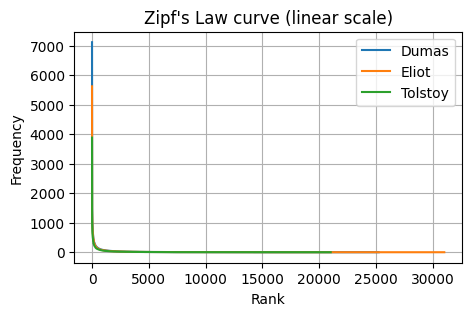

In [4]:
# Zipf's Law curve (linear scale)
plt.figure(figsize=(5, 3))
for i, author in enumerate(author_corpus):
    word_freq = Counter(author_corpus[author]['tokens_wosw'])
    word_freq_ranked = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    zipf_curve = np.array(list(word_freq_ranked.values()))
    x = np.arange(len(zipf_curve))+1
    
    plt.plot(x, zipf_curve , label=author.title())
    plt.legend()
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.grid()

plt.title("Zipf's Law curve (linear scale)")
plt.show()

### Rank-frequency plot in log scale

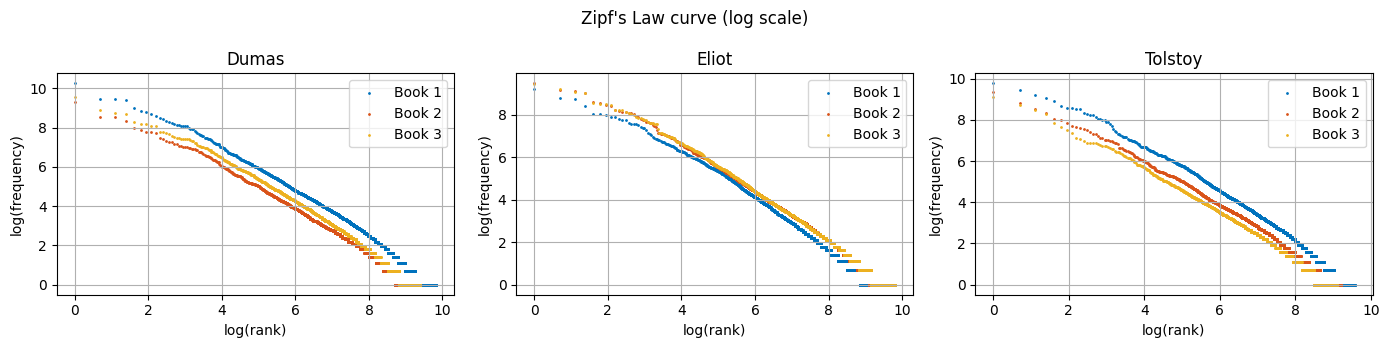

In [5]:
# Zipf's Law curve (log scale)
f, axes = plt.subplots(1,3, figsize=(14,3.5))
f.suptitle("Zipf's Law curve (log scale)")

for i, author in enumerate(author_corpus):
    tokens_per_book = author_corpus[author]['tokens_per_book']
    axes[i].set_title(author.capitalize())
    
    for k, tokens in enumerate(tokens_per_book):
        word_freq = Counter(tokens)
        word_freq_ranked = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
        zipf_curve = np.array(list(word_freq_ranked.values()))
        x = np.log(np.arange(len(zipf_curve))+1)
        y = np.log(zipf_curve)

        axes[i].scatter(x, y, s=1, label='Book %d' % (k+1), color=colors[k])
        axes[i].legend()
        axes[i].set_xlabel('log(rank)')
        axes[i].set_ylabel('log(frequency)')
        axes[i].grid()

plt.tight_layout()

### Type-token relationship (TTR) in linear and log scale

TTR implies the lexical diversity of a text. In the following, TTRs for the author-based corpus are shown.

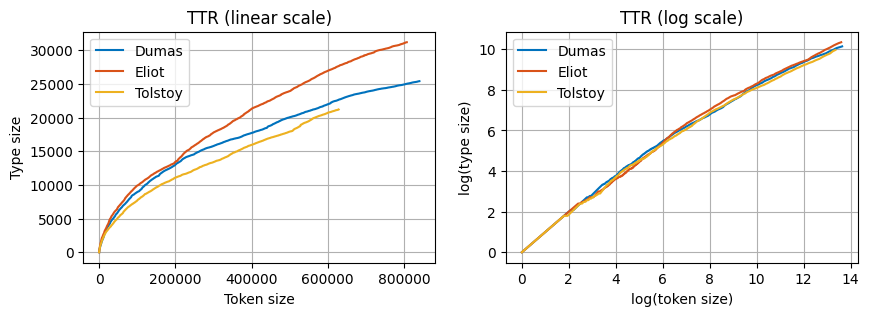

In [6]:
# Type-token relation (TTR)
for author in author_corpus:
        tokens = author_corpus[author]['tokens']
        type_size = np.zeros(len(tokens))
        types = []
        n_type = 0

        for i, token in enumerate(tokens):
            # Get unique tokens (types)
            if token not in types:
                types.append(token)
                n_type += 1

            type_size[i] = n_type
            
        # Add type size info to corresponding author corpora
        author_corpus[author]['type_size'] = type_size


# Plot type-token size relationship in linear and log scale
f, axes = plt.subplots(1,2, figsize=(10,3))

for i, author in enumerate(author_corpus):
    type_size = author_corpus[author]['type_size']
    axes[0].plot(type_size , label=author.title(), color=colors[i])

axes[0].legend()
axes[0].set_title('TTR (linear scale)')
axes[0].set_xlabel('Token size')
axes[0].set_ylabel('Type size')
axes[0].grid()

# Log-scale
for i, author in enumerate(author_corpus):
    type_size = author_corpus[author]['type_size']
    x = np.log(np.arange(len(type_size))+1)
    axes[1].plot(x, np.log(type_size), label=author.title(), color=colors[i])

axes[1].legend()
axes[1].set_title('TTR (log scale)')
axes[1].set_xlabel('log(token size)')
axes[1].set_ylabel('log(type size)')
axes[1].grid()

### Type-token relationship (TTR) per book in linear and log scale

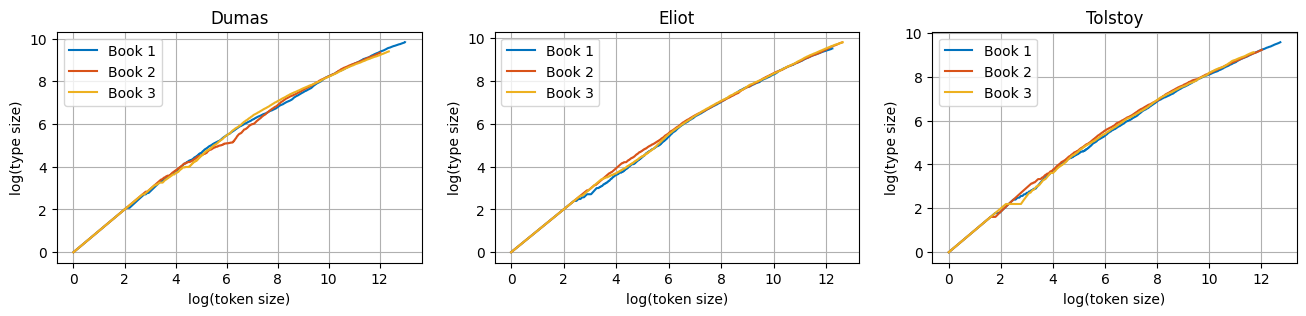

In [7]:
# Type-token relation for each book
for author in author_corpus:
    tokens_per_book = author_corpus[author]['tokens_per_book']
    # Pre-allocation for type size for each book
    author_corpus[author]['type_size_per_book'] = [None]*len(tokens_per_book)
    for book_idx, tokens in enumerate(tokens_per_book):
        type_size = np.zeros(len(tokens))
        types = []
        
        # Moving window in tokens
        n_type = 0
        for i, token in enumerate(tokens):
            if token not in types:
                types.append(token)
                n_type += 1

            type_size[i] = n_type

        # Add type size info to corresponding author corpora
        author_corpus[author]['type_size_per_book'][book_idx] = type_size


# Plot type-token size relationship per book (log scale)
f, axes = plt.subplots(1,3, figsize=(16,3))
for i, author in enumerate(author_corpus):
    type_sizes = author_corpus[author]['type_size_per_book']
    axes[i].set_title(author.capitalize())
    
    for k, type_size in enumerate(type_sizes):
        x1 = np.log(np.arange(len(type_size))+1)
        axes[i].plot(x1, np.log(type_size), label='Book %d' % (k+1), color=colors[k])

    axes[i].legend()
    axes[i].set_xlabel('log(token size)')
    axes[i].set_ylabel('log(type size)')
    axes[i].grid()

### Line fitting to TTRs

The TTR in log scale shows a linear relationship that can be approximated by a line. In the following, we find the slope (m) and offset (c) of line fits via the linear least-squares. The greater value of slope implies lexical richness. 

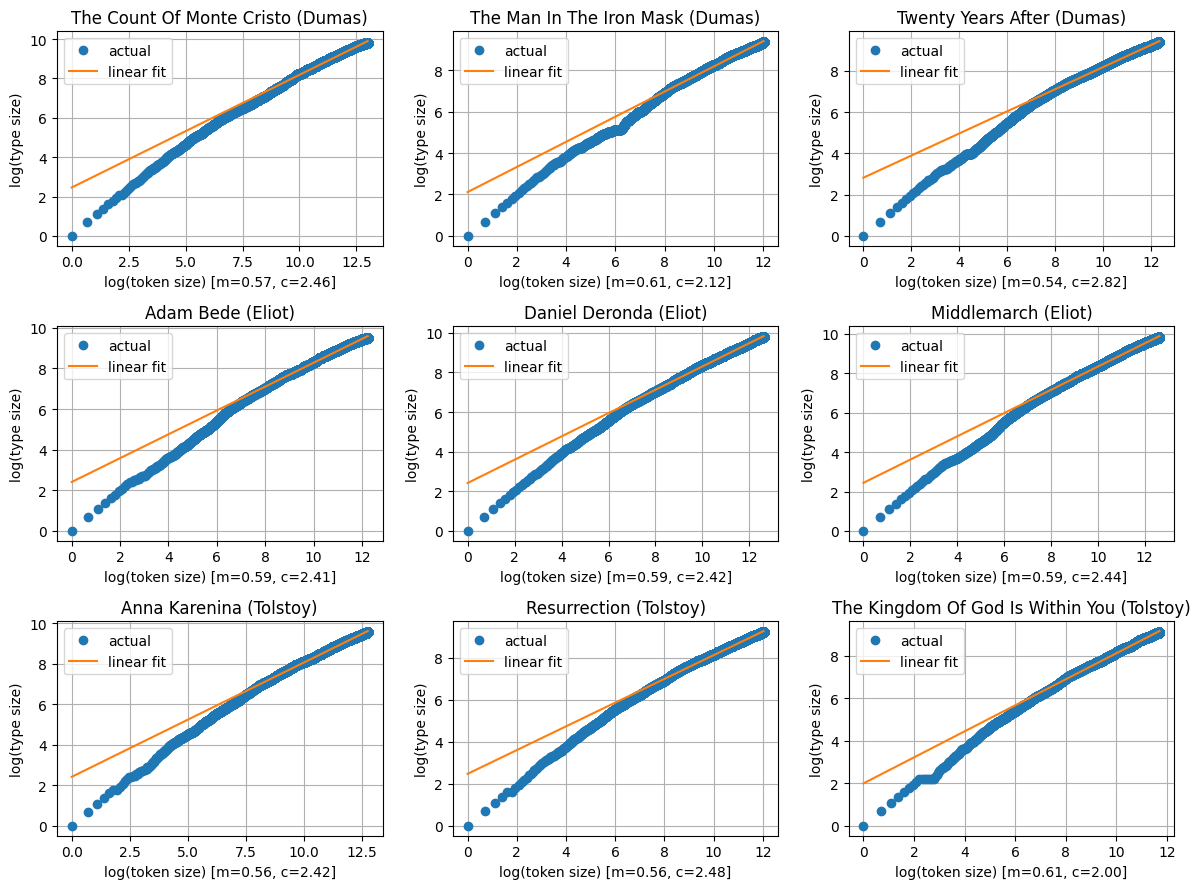

In [8]:
# Line fitting to TTRs (type-token ratios)
plt.figure(figsize=(12, 9))
for i, author in enumerate(author_corpus):
    type_size_per_book = author_corpus[author]['type_size_per_book']

    for k, type_size in enumerate(type_size_per_book):
        type_size_log = np.log(type_size)

        # Linear least -squares
        x = np.log(np.arange(len(type_size))+1)
        A = np.vstack([x, np.ones(len(x))]).T
        y = type_size_log
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]

        plt.subplot(3, 3, 3*i+(k+1))
        plt.plot(x, y, 'o', label='actual')
        plt.plot(x, m*x+c, label='linear fit')
        book_name = text_info['authors'][author][k].replace('_', ' ')
        plt.title('%s (%s)' % (book_name.title(), author.title()))
        plt.xlabel('log(token size) [m=%.2f, c=%.2f]' % (m, c))
        plt.ylabel('log(type size)')
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()